## Run Decipher on T Cells <a class="tocSkip">

Load unintegrated counts and train Decipher on T cells to investigate joint trajectories.

Author: Kevin Hoffer-Hawlik

In [56]:
import warnings; warnings.simplefilter(action='ignore',)

In [2]:
warnings.simplefilter(action='ignore',)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as colormaps
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
import scvi
import seaborn as sns
import scipy.stats
import pickle
import seaborn as sns
import tqdm.notebook
import torch
import pyro

from scipy import interpolate, ndimage

# originally implemented package, see Github for more details
from decipher.decipher_model import DecipherConfig, Decipher
from decipher.decipher_training import train_simple, plot_decipher
from decipher.load_data import palette_original
from decipher.post_analysis import *
from decipher.post_analysis_plotting import *

from basis_decomposition.inference import *
from basis_decomposition.model import *
from basis_decomposition.run import *

Global seed set to 0
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/kh3205/anaconda3/envs/scvi-scib/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [ ]:
def edit_outliers(ad, outlier_direction, k, remove = True, plot=True):
    """
    Removes visual distortions that Decipher is prone to making by removing outlier cells.
    Take outlier in 'north', 'east', 'south', or 'west' direction and place closer to global structure. 
    k refers to placement: set k = -2 to move to second largest, or k = 1 for second smallest.
    Set remove parameter to true if desiring to remove datapoint.
    """
    ad = ad.copy()
    decipher_v = ad.obsm['decipher_v'] # first index is the cell, second index is decipher_v1 (0) or decipher_v2 (1)
    
    if outlier_direction == 'north':
        index = decipher_v[:,1].argmax() # largest value in decipher_v2 span
        fix_value = np.partition(decipher_v[:,1], k)[k] # second largest value
        ad.obsm['decipher_v'][index,1] = fix_value
    elif outlier_direction == 'east':
        index = decipher_v[:,0].argmax() # largest value in decipher_v1 span
        fix_value = np.partition(decipher_v[:,0], k)[k] # second largest value
        ad.obsm['decipher_v'][index,0] = fix_value
    elif outlier_direction == 'south':
        index = decipher_v[:,1].argmin() # smallest value in decipher_v2 span
        fix_value = np.partition(decipher_v[:,1], k)[k] # second smallest value
        ad.obsm['decipher_v'][index,1] = fix_value
    elif outlier_direction == 'west':
        index = decipher_v[:,0].argmin() # smallest value in decipher_v1 span
        fix_value = np.partition(decipher_v[:,0], k)[k] # second smallest value
        ad.obsm['decipher_v'][index,0] = fix_value
        
    if remove:
        mask = np.full((ad.shape[0],),True)
        mask[index] = False
        ad = ad[mask,:]
    
    if plot:
        sc.pl.embedding(ad, basis='decipher_v')
    return ad

In [5]:
def subsample_for_R310(adata, final_R310_on_number):
    ad_R310_on1 = adata[adata.obs['sample']=='R310_on1',:]
    ad_R310_on2 = adata[adata.obs['sample']=='R310_on2',:]
    ad_other = adata[~adata.obs['sample'].isin(['R310_on1','R310_on2']),:]
    print(ad_R310_on1.shape)
    print(ad_R310_on2.shape)
    print(ad_other.shape)
    
    sc.pp.subsample(ad_R310_on1, n_obs = final_R310_on_number//2, random_state = 4030) # change random_state each time
    sc.pp.subsample(ad_R310_on2, n_obs = final_R310_on_number//2, random_state = 4044) # change random_state each time
    print(ad_R310_on1.shape)
    print(ad_R310_on2.shape)
    
    adata = ad.concat([ad_R310_on1, ad_R310_on2, ad_other], axis=0)
    print(adata.shape)
    return adata

## Load data

In [ ]:
# use non-normalized counts for training
tcells_filepath = 'tcells_unintegrated_030823.h5ad'
marker_genes_filepath = 'marker_genes_dict_030823.pickle'

tcells = sc.read_h5ad(tcells_filepath)

with open(marker_genes_filepath, 'rb') as handle:
    marker_genes = pickle.load(handle)

tcells.shape

(23658, 8170)

In [ ]:
# import labels and other metadata
tcells_obs = sc.read_h5ad('tcells_scvi_annotated_041023.h5ad')
tcells_obs = tcells_obs.obs
tcells_obs
tcells.obs = tcells_obs

In [9]:
signatures = ["activation_markers_z_score_scvi_normalized",
              "exhaustion_markers_z_score_scvi_normalized",
              "CD8_T_cell_activation_z_score_scvi_normalized",
              "Type_II_interferon_response_z_score_scvi_normalized",
              "Exhaustion/Terminal_differentiation_z_score_scvi_normalized",
              "CD8_TIL_dysfunction_z_score_scvi_normalized",
              "T_cell_co-inhibitory_receptors_z_score_scvi_normalized",
              "naive_markers_z_score_scvi_normalized",
              "effector_cytokines_z_score_scvi_normalized",
              
              "Terminal_exhaustion_z_score_scvi_normalized", 
              "Precursor_exhaustion_z_score_scvi_normalized", 
              "T_naive_z_score_scvi_normalized", 
              "T_stem_central_memory_z_score_scvi_normalized", 
              "T_central_memory_z_score_scvi_normalized", 
              "T_effector_memory_z_score_scvi_normalized", 
              "T_terminal_effector_z_score_scvi_normalized", 
             ]

full_signatures = [s + '_z_score_scvi_normalized' for s in list(marker_genes.keys())[1:]]

In [11]:
tcells.X = tcells.layers['counts'] # set non-norm/log layer as default layer

# Main

## Run decipher on T cells only

In [22]:
adata = tcells[tcells.obs.cell_type_khh.isin(['CD4+ T','CD8+ T','Naive CD4+ T',
                                                      'Naive CD8+ T','Treg','naive Treg']),:]
adata.shape

(20513, 8170)

In [23]:
adata.obs.loc[adata.obs['cell_type_khh']=='naive Treg','cell_type_khh'] = 'Treg'
adata.obs.cell_type_khh = adata.obs.cell_type_khh.cat.remove_categories('naive Treg')

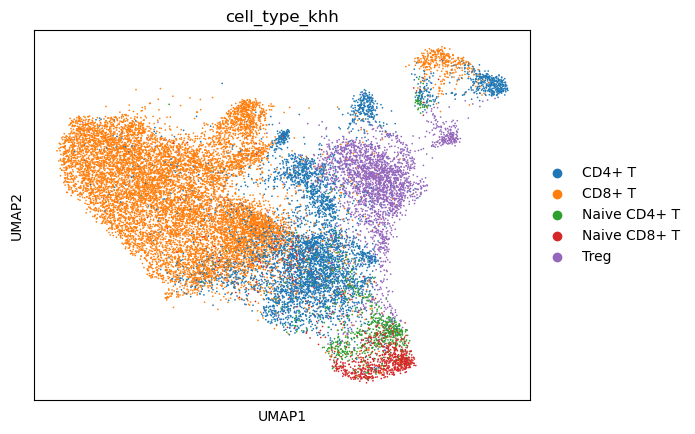

In [24]:
sc.pl.umap(adata, color='cell_type_khh')

In [25]:
config = DecipherConfig(
    latent_dim=10,
    pre_latent_dim=2,
    z_to_x_layers=[],
    seed=2,
    beta=1e-1,
    p_to_z_layers=(64,)
)

V4
[Epoch 0000]  Loss: 29174408.97342


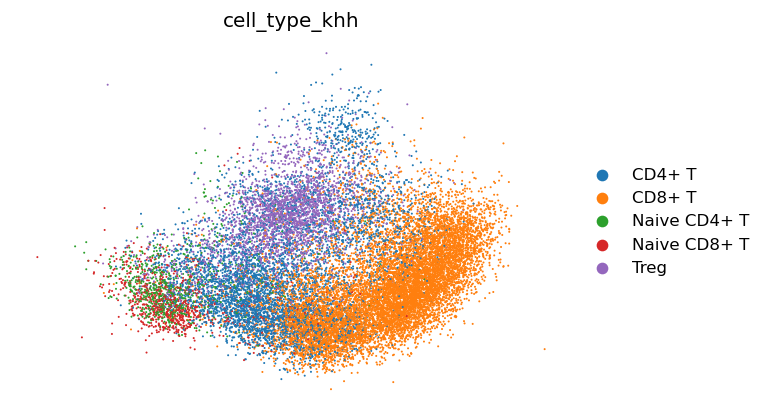

[Epoch 0005]  Loss: 27038803.78004


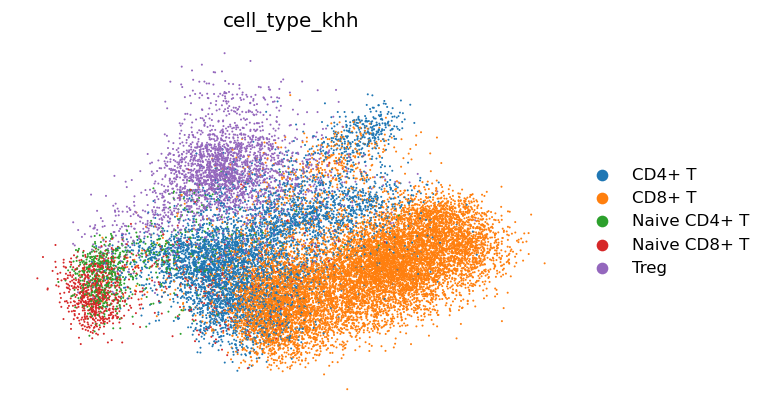

[Epoch 0010]  Loss: 26888781.08016


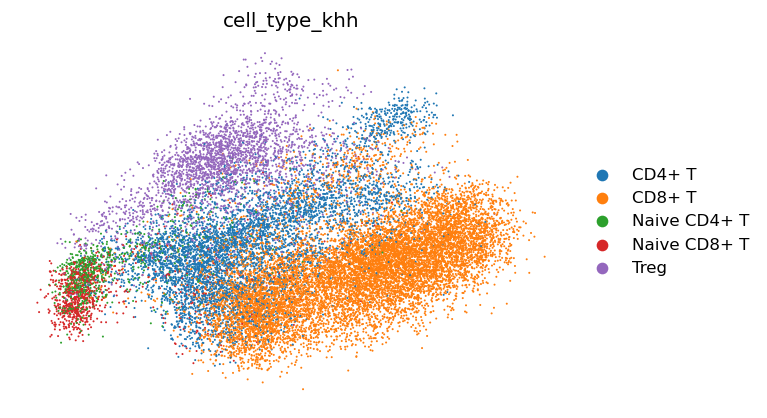

[Epoch 0015]  Loss: 26856969.89258


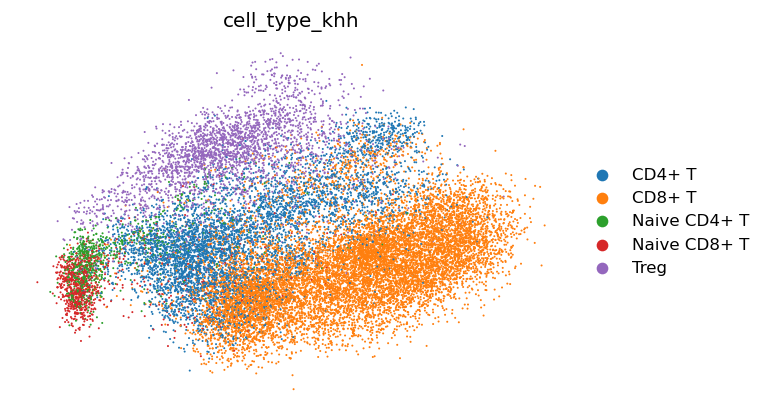

[Epoch 0020]  Loss: 26841346.15814


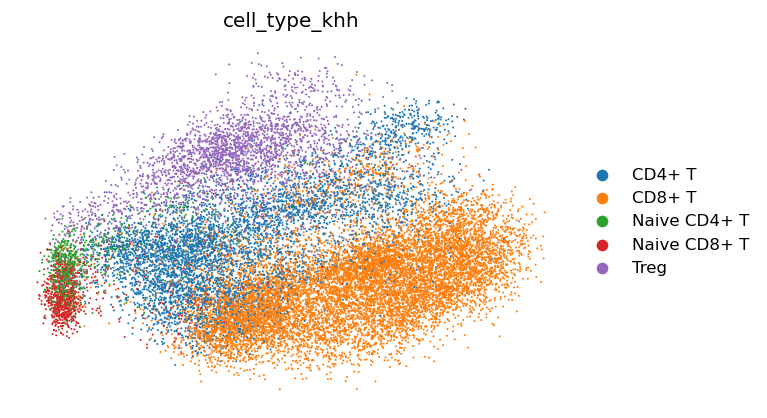

[Epoch 0025]  Loss: 26826168.10512


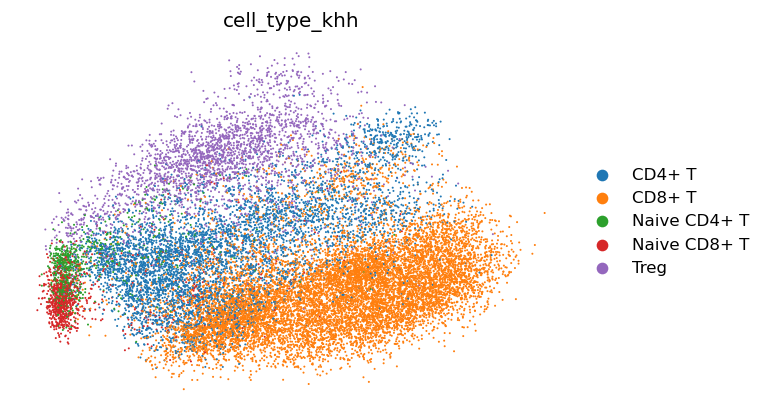

[Epoch 0030]  Loss: 26822341.26914


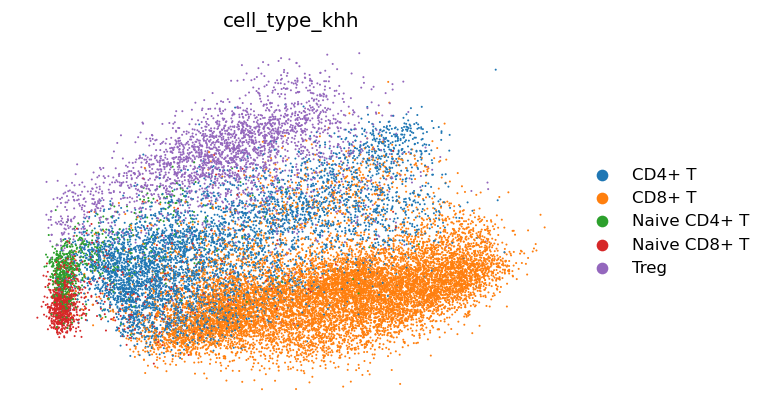

[Epoch 0035]  Loss: 26805462.09480


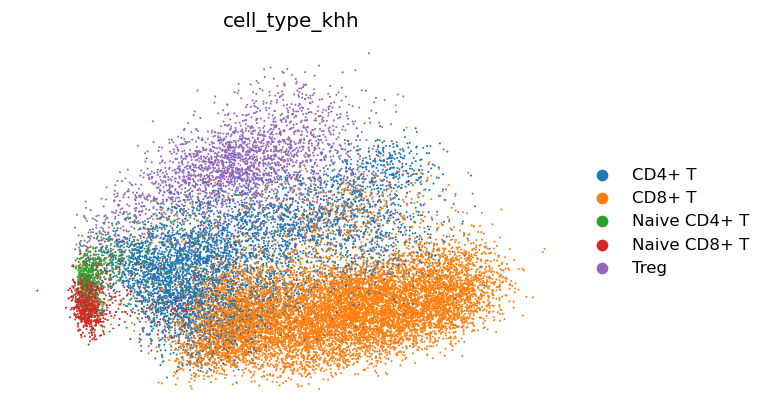

[Epoch 0040]  Loss: 26797368.66717


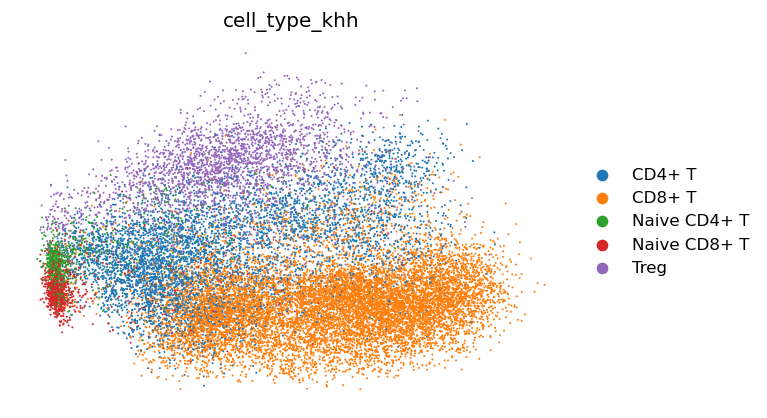

[Epoch 0045]  Loss: 26784641.90754


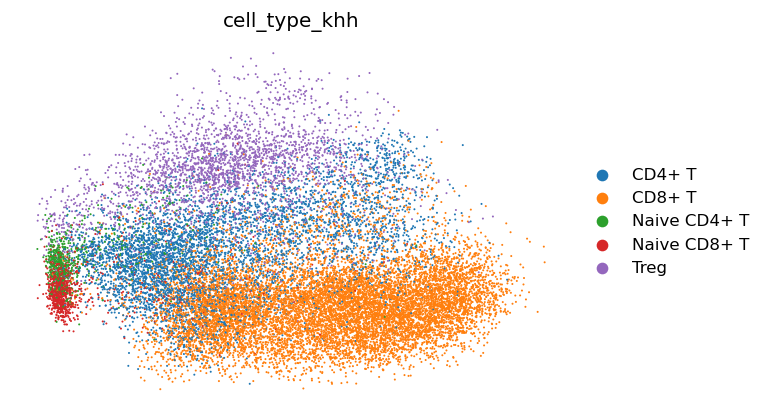

[Epoch 0050]  Loss: 26784710.81623


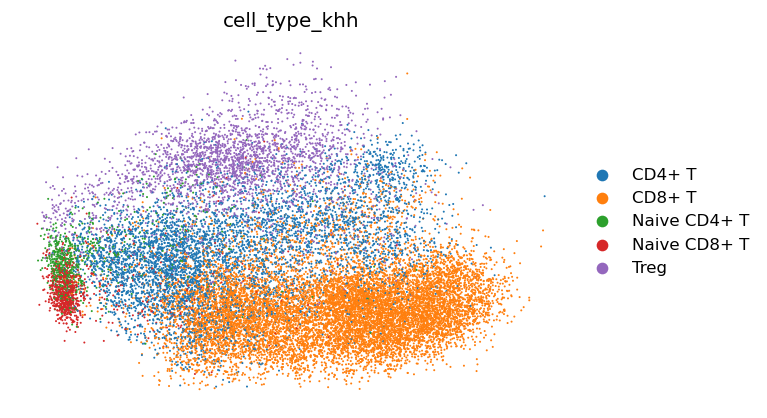

[Epoch 0055]  Loss: 26776315.59644


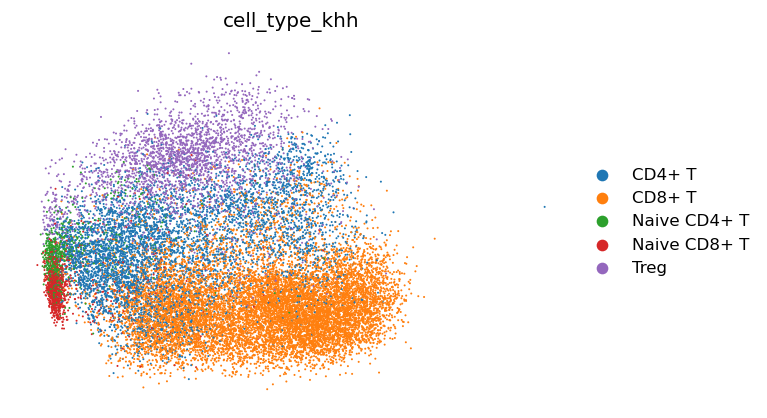

[Epoch 0060]  Loss: 26769679.94312


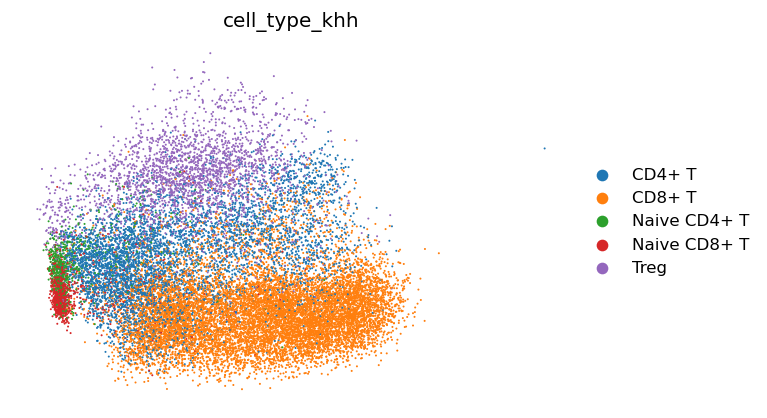

In [27]:
model, adata, loss = train_simple(
    adata,
    config,
    learning_rate=1e-2,
    n_epochs=61,
    plot_every_k_epoch=5,
    plot_kwargs=dict(color=["cell_type_khh"],),
)

In [ ]:
def decipher_save_model(adata, model, config, overwrite=False):
    import logging, os
    import dataclasses
    from dataclasses import dataclass
    
    DECIPHER_GLOBALS = dict()
    DECIPHER_GLOBALS["save_folder"] = "./_decipher_models/"

    def create_decipher_uns_key(adata):
        if "decipher" not in adata.uns:
            adata.uns["decipher"] = dict()
        if "trajectories" not in adata.uns["decipher"]:
            adata.uns["decipher"]["trajectories"] = dict()
    
    def get_random_name(seed=None):
        name = 'tcells_rerun'
        datetime_str = time.strftime("%Y-%m-%d-%H-%M-%S")
        return f"{datetime_str}-{name}"
    
    def to_dict(self):
        res = dataclasses.asdict(self)
        res["layers_v_to_z"] = list(res["p_to_z_layers"])
        res["layers_z_to_x"] = list(res["z_to_x_layers"])
        return res
    
    create_decipher_uns_key(adata)

    if "run_id_history" not in adata.uns["decipher"]:
        adata.uns["decipher"]["run_id_history"] = []

    if "run_id" not in adata.uns["decipher"] or not overwrite:
        adata.uns["decipher"]["run_id"] = get_random_name()
        adata.uns["decipher"]["run_id_history"].append(adata.uns["decipher"]["run_id"])
        logging.info(f"Saving decipher model with run_id {adata.uns['decipher']['run_id']}.")
    else:
        logging.info("Overwriting existing decipher model.")

    model_run_id = adata.uns["decipher"]["run_id"]
    save_folder = DECIPHER_GLOBALS["save_folder"]
    full_path = os.path.join(save_folder, model_run_id)
    os.makedirs(full_path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(full_path, "decipher_model.pt"))
    adata.uns["decipher"]["config"] = to_dict(model.decipher_config)
    adata.uns['decipher']['config']['context'] = []
    del adata.uns['decipher']['config']['p_to_z_layers'], adata.uns['decipher']['config']['z_to_x_layers']
    adata.write_h5ad(os.path.join(full_path, 'tcells.h5ad'))

# save model and anndata for downstream analyses
decipher_save_model(adata, model, config)

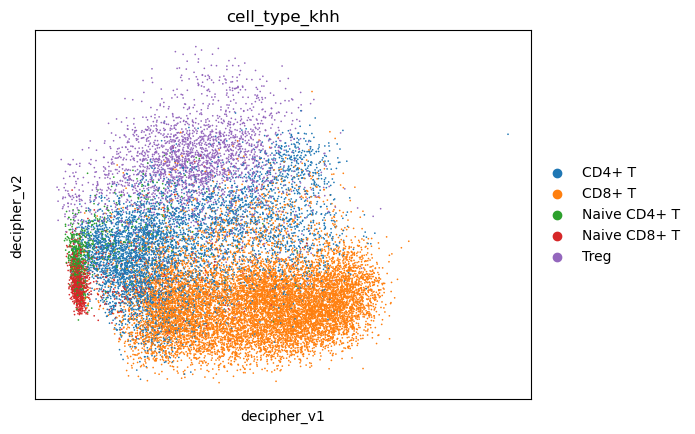

In [68]:
sc.pl.embedding(adata, basis = 'decipher_v', color='cell_type_khh')

In [70]:
adata = edit_outliers(adata, outlier_direction = 'east', k = 1, remove = True, plot=False)

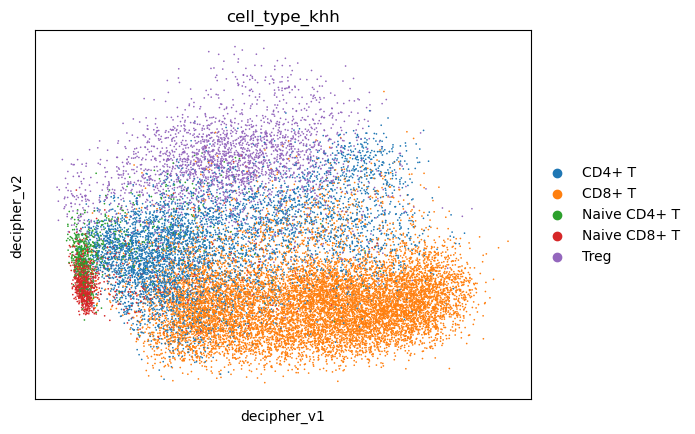

In [71]:
sc.pl.embedding(adata, basis = 'decipher_v', color='cell_type_khh')

## examine trajectories from CD4+ & CD8+ T cell dataset

### calculate trajectories

We ideally want Decipher 1 to capture treatment effects, and Decipher 2 to discriminate CD8+ from CD4+ and Treg cells

In [ ]:
# adata.obsm['decipher_v'] = adata.obsm['decipher_v_not_rotated'] # to undo rotation
# adata.obsm['decipher_z'] = adata.obsm['decipher_z_not_rotated'] # to undo rotation
adata.obsm['decipher_v'][:,1] = -adata.obsm['decipher_v'][:,1] # flip y axis

In [20]:
cluster_representations(adata, leiden_resolution = 10.0) # default 1.0

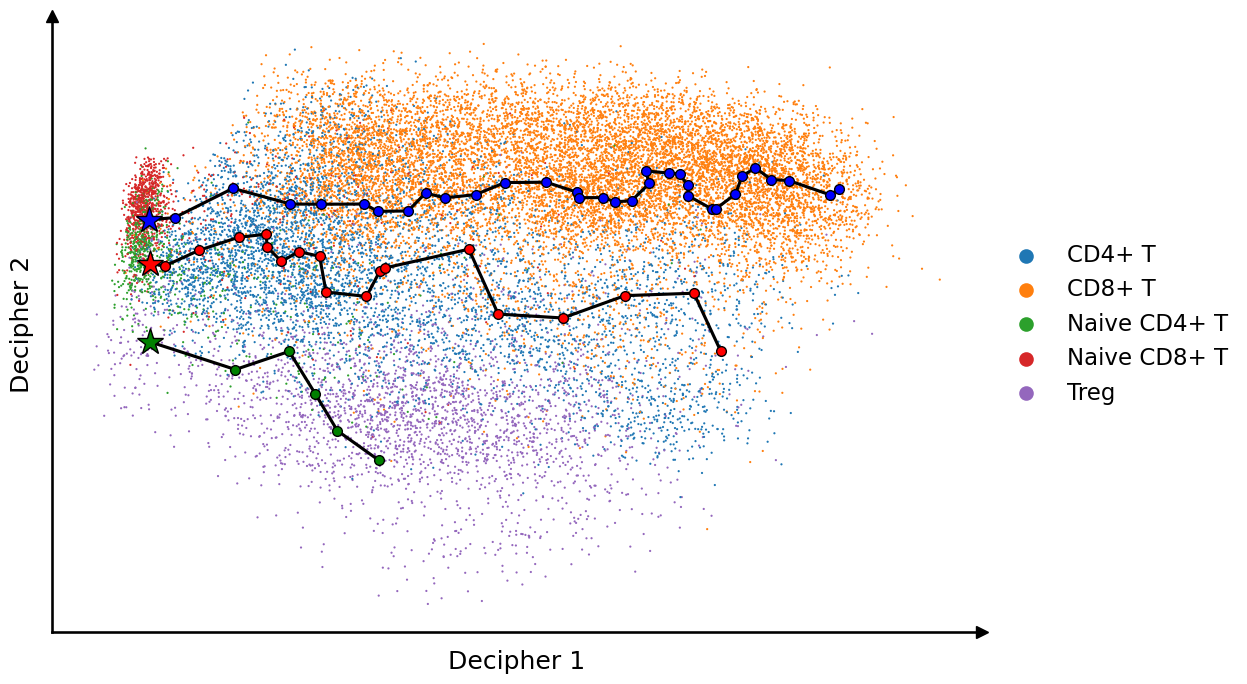

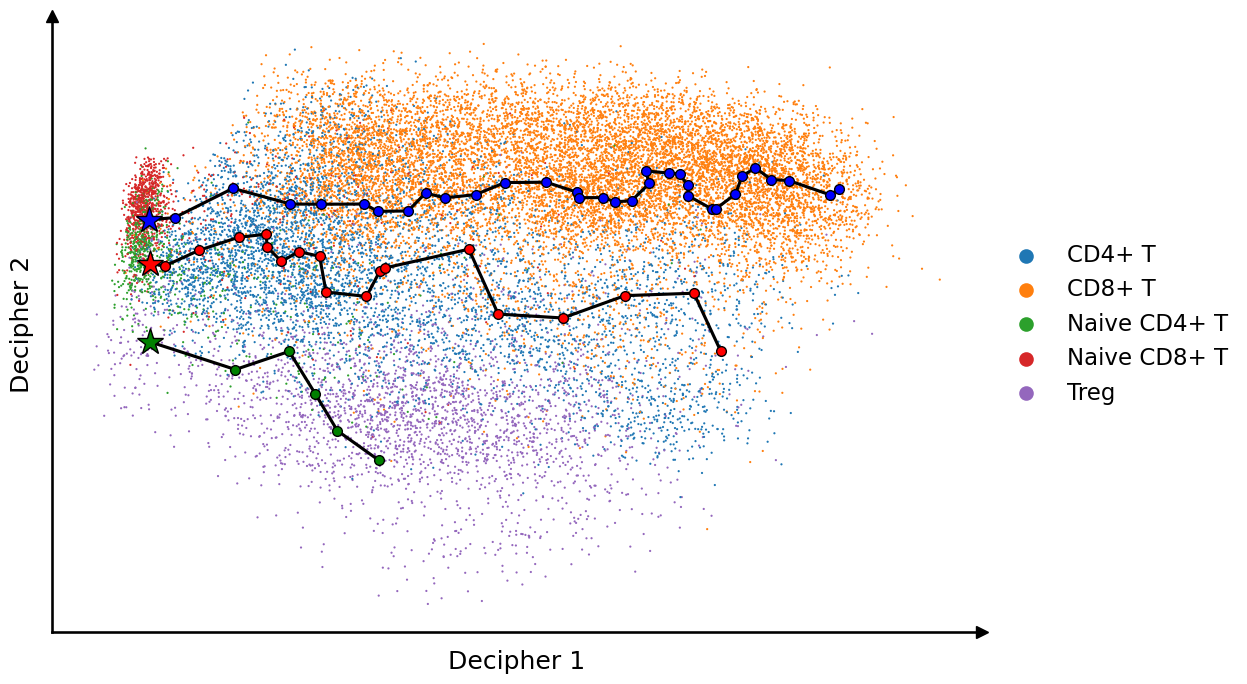

In [21]:
# create trajectories for CD8, CD4, and Treg cells, respectively
replace_markers = {
    'CD4+ T': 'CD4',
    'CD8+ T': 'CD8',
    'Naive CD4+ T': 'CD4',
    'Naive CD8+ T': 'CD8',
    'Treg': 'Treg',
    'naive Treg': 'Treg',
}
adata_T.obs['marker'] = adata_T.obs['cell_type_khh'].replace(replace_markers)

cd8_trajectory = compute_trajectories(adata_T, 
                                  start_marker = 'SELL', 
                                  end_marker = 'TIGIT',
                                  subset_column = 'marker',
                                  subset_value = 'CD8', 
                                  trajectory_point_density = 10, # default 50
                                  cell_types_key = 'cell_type_khh'
                                 )

cd4_trajectory = compute_trajectories(adata_T, 
                                  start_marker = 'SELL', 
                                  end_marker = 'TIGIT',
                                  subset_column = 'marker',
                                  subset_value = 'CD4', 
                                  trajectory_point_density = 10, # default 50
                                  cell_types_key = 'cell_type_khh'
                                 )

Treg_trajectory = compute_trajectories(adata_T, 
                                  start_marker = 'SELL', 
                                  end_marker = 'TIGIT',
                                  subset_column = 'marker',
                                  subset_value = 'Treg', 
                                  trajectory_point_density = 10, # default 50
                                  cell_types_key = 'cell_type_khh'
                                 )

# adata_T.obs.loc[adata_T.obs['cell_type_khh']=='naive Treg','cell_type_khh'] = 'Treg'
# adata_T.obs.cell_type_khh = adata_T.obs.cell_type_khh.cat.remove_categories('naive Treg')

fig = plot_decipher_v(adata_T, 'cell_type_khh', figsize=(12,8), s=10)

plot_trajectory(
    fig.axes[0],
    trajectory = cd8_trajectory, 
#     f"origin={patient_name}",
#     palette_original[patient_name],
)
plot_trajectory(
    fig.axes[0],
    trajectory = cd4_trajectory, 
    color = 'red',
)

plot_trajectory(
    fig.axes[0],
    trajectory = Treg_trajectory, 
    color = 'green',
)

fig

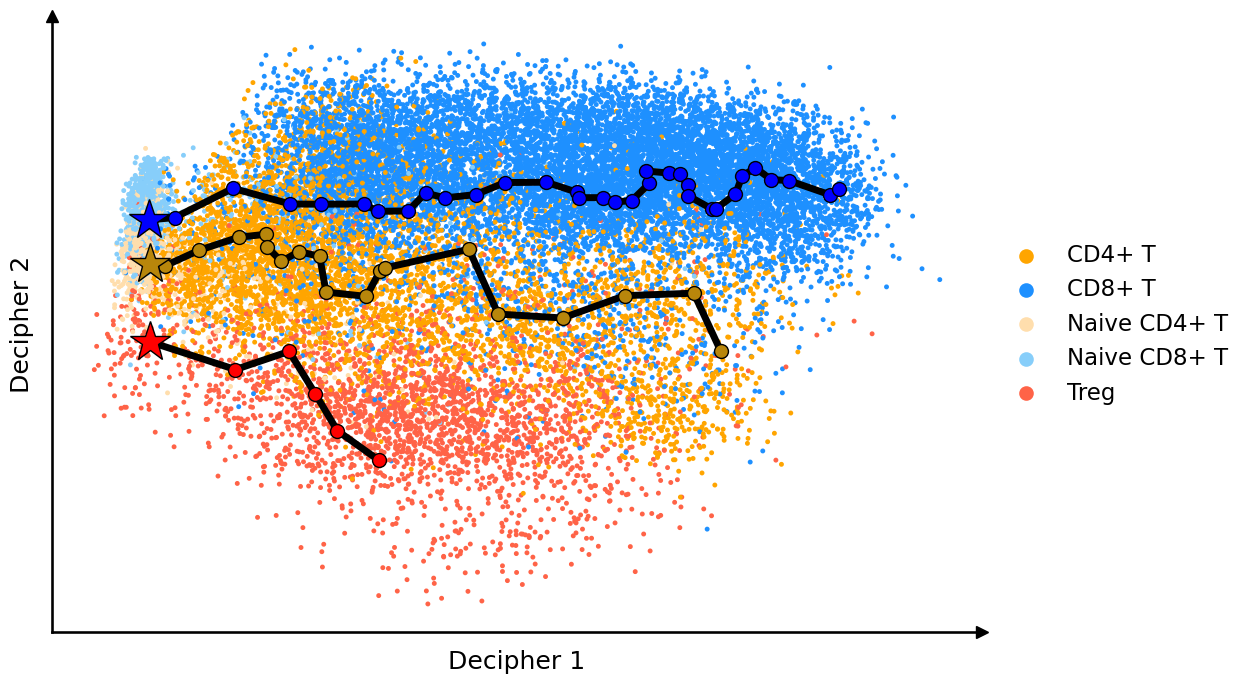

In [56]:
# custom plotting for presentations/posters/abstracts
def plot_trajectory(
    ax,
    trajectory,
    color="blue",
    o_size=7,
    star_size=20,
    linewidth=3
):
    ax.plot(
        trajectory.checkpoints[:, 0],
        trajectory.checkpoints[:, 1],
        marker="o",
        c="black",
        markerfacecolor=color,
        markersize=o_size,
        linewidth=linewidth,
    )
    ax.plot(
        trajectory.checkpoints[:1, 0],
        trajectory.checkpoints[:1, 1],
        marker="*",
        markersize=star_size,
        c="black",
        markerfacecolor=color,
    )

cell_type_khh_palette = ['navajowhite','darkorange','red','lightskyblue','blue',
                         'mediumpurple','indigo','yellow']

fig = plot_decipher_v(adata_T, 'cell_type_khh', figsize=(12,8), 
                      palette = ['orange','dodgerblue','navajowhite','lightskyblue','tomato'], s=50)

plot_trajectory(
    fig.axes[0],
    trajectory = cd8_trajectory,
    color= 'blue',
    o_size=10,
    star_size=30,
    linewidth=5
)
plot_trajectory(
    fig.axes[0],
    trajectory = cd4_trajectory, 
    color = 'darkgoldenrod',
    o_size=10,
    star_size=30,
    linewidth=5
)
plot_trajectory(
    fig.axes[0],
    trajectory = Treg_trajectory, 
    color = 'red',
    o_size=10,
    star_size=30,
    linewidth=5
)



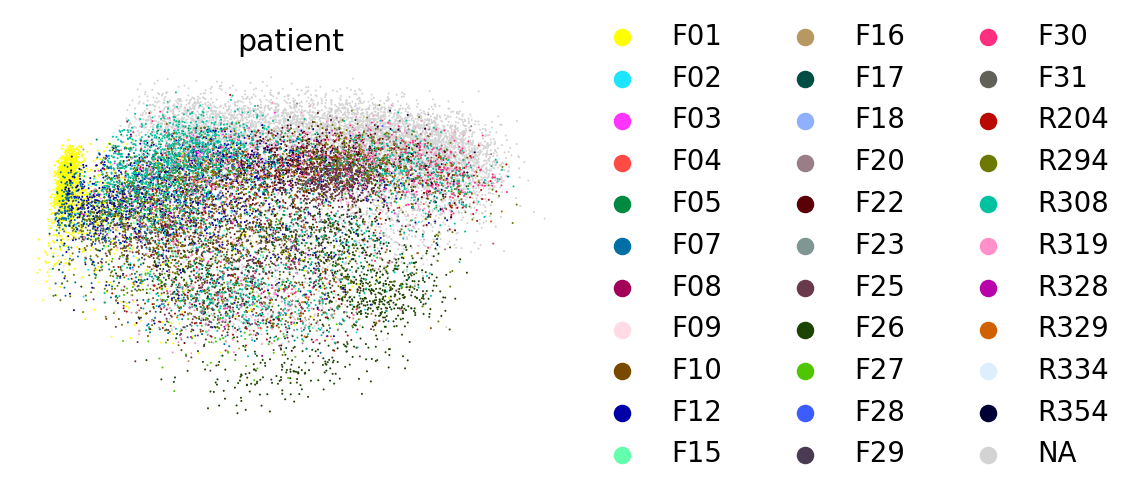

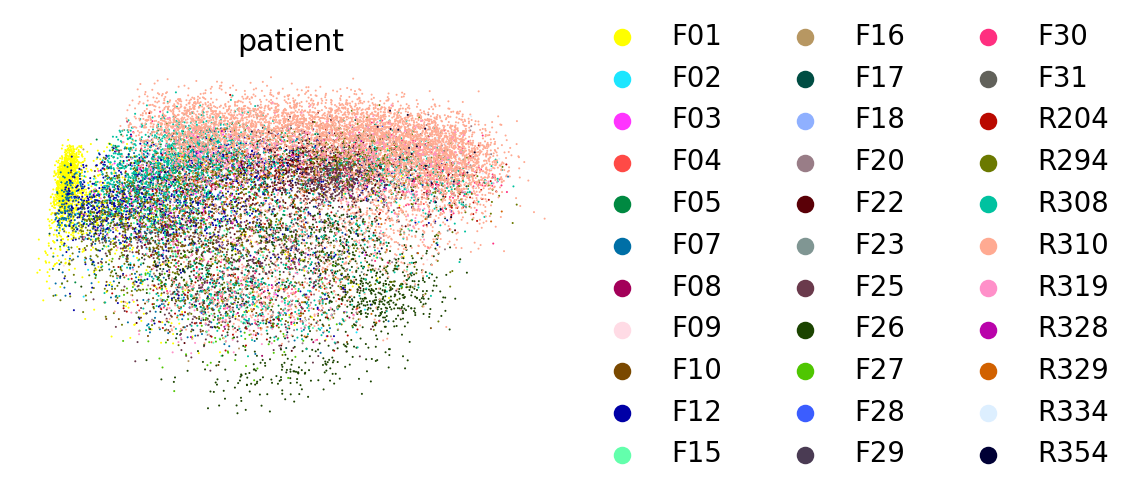

In [ ]:
# color by all patients other than R310
patient_list = list(adata_T.obs.patient.unique())
patient_list.remove('R310')
plot_decipher(adata_T, color = 'patient', groups = patient_list)
plot_decipher(adata_T, color = 'patient', )#groups = patient_list)

## Compute decipher time

0.46238159179687494 4.6774549865722665


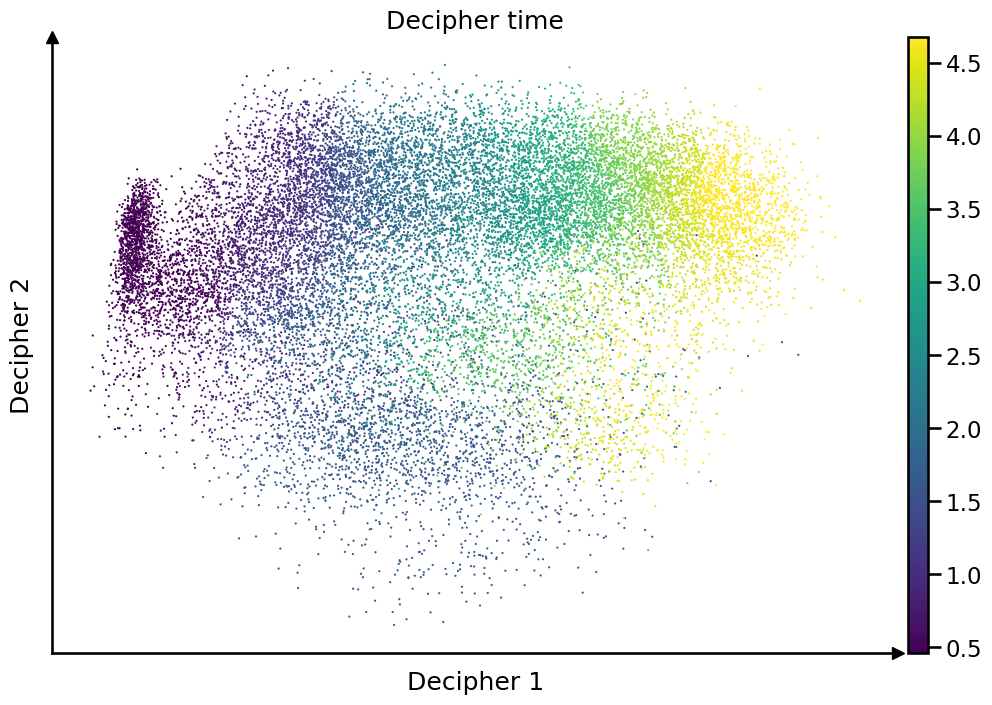

In [ ]:
adata.obs['origin'] = adata.obs['marker'] # version implementation bug

compute_decipher_time(adata, {'CD8':cd8_trajectory, 'CD4':cd4_trajectory, 'Treg':Treg_trajectory})
dtime_min, dtime_max = adata.obs.decipher_time.min(), adata.obs.decipher_time.max()
print(dtime_min, dtime_max)

fig = plot_decipher_v(adata, "decipher_time", figsize=(12,8), s=10, title='Decipher time')
plt.show()

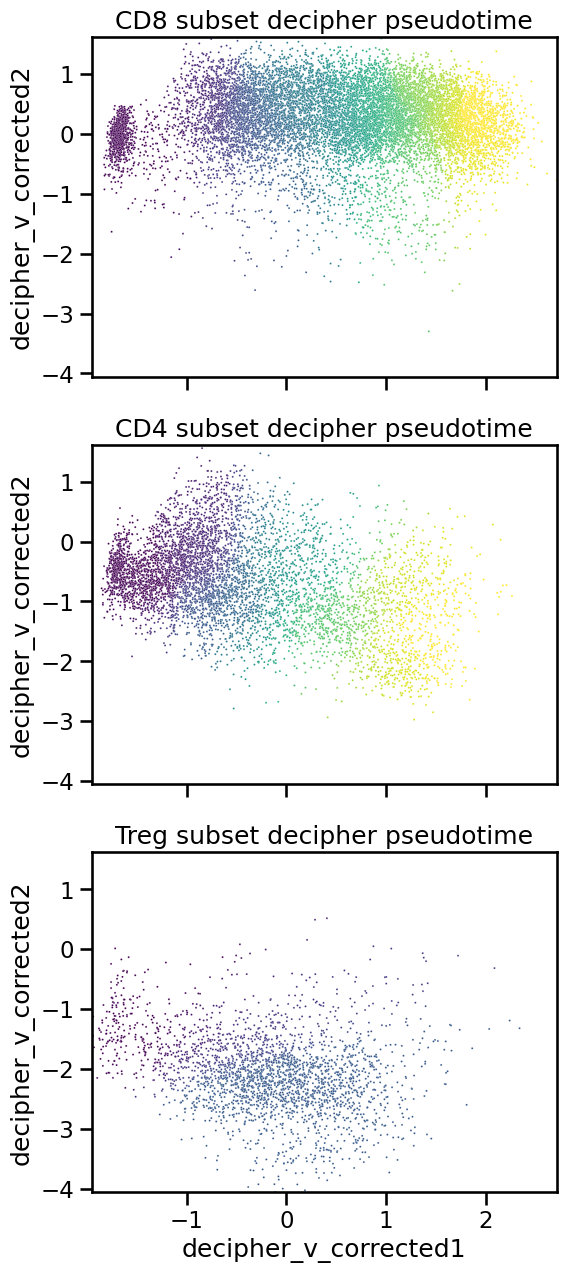

In [ ]:
adata.obs.loc[:,'decipher_v_corrected1'] = adata.obsm['decipher_v_corrected'][:,0]
adata.obs.loc[:,'decipher_v_corrected2'] = adata.obsm['decipher_v_corrected'][:,1]
df = adata.obs
v1max = np.max(df.decipher_v_corrected1)
v1min = np.min(df.decipher_v_corrected1)
v2max = np.max(df.decipher_v_corrected2)
v2min = np.min(df.decipher_v_corrected2)

fig, axs = plt.subplots(3,1, figsize=(6,15), sharex=True)
for i, marker in enumerate(['CD8','CD4','Treg']):
    sns.scatterplot(data = df.loc[df.marker==marker, :], x = 'decipher_v_corrected1', y = 'decipher_v_corrected2', 
                    hue = 'decipher_time', ax=axs[i], s = 2, palette = 'viridis', hue_norm=(dtime_min,dtime_max))
    axs[i].set_xlim(v1min, v1max)
    axs[i].set_ylim(v2min, v2max)
    axs[i].set_title(marker + ' subset decipher pseudotime')
    axs[i].get_legend().remove()
    
    # plot_decipher_v(adata_T[adata_T.obs.marker==marker,:], "decipher_time", title='Decipher time (' + marker + ')', figsize=(9,4))
# fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=mpl.colors.Normalize(vmin=dtime_min, vmax=dtime_max)))
plt.show()

In [ ]:
# save trajectories for downstream analysis using polished package
adata.write('tcells_decipher_trajectories_091123.h5ad')

## examine variables, distributions along decipher_time

In [ ]:
# adata = subsample_for_R310(adata, final_R310_on_number=1900)

In [ ]:
# adata.obs['bucketed_days_to/from_ICI_start'].cat.reorder_categories(['<0','0-23','24-103','104-187','188+'], inplace=True)
# adata.obs['bucketed_OS'].cat.reorder_categories(['0-390','391-439','440-616','617-730','731+'], inplace=True)
# adata.obs['mutation_category'].cat.reorder_categories(['mutant','non-mutant'], inplace=True)

In [ ]:
df = adata.obs#.loc[adata.obs.cell_type_khh != 'Naive CD8+ T',:]
# df = df.loc[df.clone_size!='NA',:] # uncomment to include cells without TCR data
obs = 'bucketed_OS'
bins = 20
# adata.obs[obs] = adata.obs[obs].astype("category") # necessary if subsampled for R310 patient
palette = 'rocket' 
dtime_min, dtime_max = adata.obs.decipher_time.min(), adata.obs.decipher_time.max()

fig, (ax1,ax2) = plt.subplots(2,1, sharex = 'col')
sns.histplot(data = df, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='stack', stat = 'probability', ax = ax1, legend = False, palette = palette)
sns.histplot(data = df, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='fill', ax = ax2, legend = False, palette = palette)
# sns.move_legend(ax1,'upper left', bbox_to_anchor=(1,1))
fig.suptitle('T cells (combined)');

df_cd8 = df.loc[df.marker == 'CD8',:]
fig_2, (ax1_2,ax2_2) = plt.subplots(2,1, sharex = 'col')
sns.histplot(data = df_cd8, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='stack', stat = 'probability', ax = ax1_2, legend = False, palette = palette)
sns.histplot(data = df_cd8, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='fill', ax = ax2_2, legend = False, palette = palette)
# sns.move_legend(ax1_2,'upper left', bbox_to_anchor=(1,1))
fig_2.suptitle('CD8+ T cells');

df_cd4 = df.loc[df.marker == 'CD4',:]
fig_3, (ax1_3,ax2_3) = plt.subplots(2,1, sharex = 'col')
sns.histplot(data = df_cd4, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='stack', stat = 'probability', ax = ax1_3, legend = False, palette = palette)
sns.histplot(data = df_cd4, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='fill', ax = ax2_3, legend = False, palette = palette)
# sns.move_legend(ax1_3,'upper left', bbox_to_anchor=(1,1))
fig_3.suptitle('CD4+ T cells');

df_Treg = df.loc[df.marker == 'Treg',:]
fig_4, (ax1_4,ax2_4) = plt.subplots(2,1, sharex = 'col')
sns.histplot(data = df_Treg, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='stack', stat = 'probability', ax = ax1_4, legend = False, palette = palette)
sns.histplot(data = df_Treg, x = 'decipher_time', hue = obs, bins=bins, binrange = (dtime_min, dtime_max), multiple='fill', ax = ax2_4, legend = False, palette = palette)
# sns.move_legend(ax1_4,'upper left', bbox_to_anchor=(1,1))
fig_4.suptitle('Tregs');

plt.show()